In [1]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, average_precision_score, auc, brier_score_loss, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve
import pandas as pd
import numpy as np
from math import floor
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
import sklearn
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns

from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
sentinels = ['None', 'n.d.', ' ', '']
df = pd.read_csv('assets/yid_out.tsv', sep='\t', na_values=sentinels)
print("df.shape: ", df.shape)

df.shape:  (70031, 26)


In [3]:
df.valoreIntero.fillna(df.valoreIntero.mean(), inplace=True)
df.mediaVoto.fillna(df.mediaVoto.mean(), inplace=True)
df.votoDiploma.fillna(round(df.votoDiploma.mean()), inplace=True)


df = df.drop(['luogoDiNascita', 'nazioneNascita'], axis=1)
df = df.astype({'valoreIntero': np.int64, 'votoDiploma': np.int32})
# print(pd.isnull(df).sum() > 0)
print(df.shape)

(70031, 24)


In [4]:
y = df.Dropout
X = df.drop(['ID_Stud', 'Dropout', 'lastLogin', 'annoAccaCors'], axis = 1)

val = {True: 1, False: 0}
X["sesso"] = X["sesso"].map(val)
X = X.astype({'sesso': np.int32})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Training Set shape: {}".format(X_train.shape))
print("Test Set shape: {}".format(X_test.shape))

Training Set shape: (56024, 20)
Test Set shape: (14007, 20)


In [5]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
with open('assets/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)
# encoder = OneHotEncoder(handle_unknown="ignore")
feature_arr = encoder.transform(X_train[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_train = X_train.reset_index(drop=True)
X_train = X_train.join(encoded_df)
X_train = X_train.drop(ohe_elements, axis=1)
# with open('assets/encoder.pickle', 'wb') as f:
#     pickle.dump(encoder, f)
X_train.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,ultIscr,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,2,24,30822,120,1,2,1,28,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,25,30071,120,0,2,1,28,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,23,29850,180,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,23,29850,180,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,26,29949,180,0,2,1,27,2,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
# with open('assets/encoder.pickle', 'rb') as f:
#     encoder = pickle.load(f)


feature_arr = encoder.transform(X_test[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_test = X_test.reset_index(drop=True)
X_test = X_test.join(encoded_df)
X_test = X_test.drop(ohe_elements, axis=1)

X_test.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,ultIscr,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,2,22,30425,180,1,2,1,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,21,30425,180,1,2,1,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5,24,26694,300,1,6,0,23,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2,26,11028,0,1,2,1,20,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,23,30820,180,1,2,1,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
X_train = X_train.drop(['facolta_PSICOLOGIA 1'], axis=1)
X_test = X_test.drop(['facolta_PSICOLOGIA 1'], axis=1)

In [8]:

std_elements = ['codCorso', 'valoreIntero', 'creditiTotali',  'cfuPrenotati', 'cfuTake', 'mediaVoto']
X_train_std = X_train.copy()

with open('assets/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

X_train_std[std_elements] = scaler.transform(X_train_std[std_elements])

X_test_std = X_test.copy()
X_test_std[std_elements] = scaler.transform(X_test_std[std_elements])

X_train_std.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,ultIscr,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,2,24,0.977258,0.333333,1,2,1,28,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,25,0.953203,0.333333,0,2,1,28,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,23,0.946124,0.500000,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,23,0.946124,0.500000,1,4,0,27,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,26,0.949295,0.500000,0,2,1,27,2,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
def binary_fbeta(ytrue , ypred, beta=1, threshold=0.5, epsilon=1e-7):
    # epsilon is set so as to avoid division by zero error
    
    beta_squared = beta**2 # squaring beta

    # casting ytrue and ypred as float dtype
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)

    # setting values of ypred greater than the set threshold to 1 while those lesser to 0
    ypred = tf.cast(tf.greater_equal(ypred, tf.constant(threshold)), tf.float32)

    tp = tf.reduce_sum(ytrue*ypred) # calculating true positives
    predicted_positive = tf.reduce_sum(ypred) # calculating predicted positives
    actual_positive = tf.reduce_sum(ytrue) # calculating actual positives
    
    precision = tp/(predicted_positive+epsilon) # calculating precision
    recall = tp/(actual_positive+epsilon) # calculating recall
    
    # calculating fbeta
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    return fb

### Base version

In [18]:
import keras
model = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=(113,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dropout(0.2),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 113)               452       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2280      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20)                80        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 3,253
Trainable params: 2,987
Non-trainable params: 266
__________________________________________________

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(curve="ROC"), tf.keras.metrics.AUC(curve="PR"), binary_fbeta])
model.fit(X_train_std, y_train, epochs=100, validation_split=0.2, batch_size=1024)

Epoch 1/100
46/46 [==============================] - 9s 98ms/step - loss: 0.7839 - accuracy: 0.5176 - auc_2: 0.5673 - auc_3: 0.3012 - binary_fbeta: 0.3847 - val_loss: 0.6654 - val_accuracy: 0.6205 - val_auc_2: 0.5843 - val_auc_3: 0.3090 - val_binary_fbeta: 0.3539
Epoch 2/100
46/46 [==============================] - 3s 58ms/step - loss: 0.5821 - accuracy: 0.7166 - auc_2: 0.6127 - auc_3: 0.3450 - binary_fbeta: 0.2751 - val_loss: 0.5605 - val_accuracy: 0.7281 - val_auc_2: 0.6155 - val_auc_3: 0.3300 - val_binary_fbeta: 0.1939
Epoch 3/100
46/46 [==============================] - 3s 57ms/step - loss: 0.5352 - accuracy: 0.7419 - auc_2: 0.6795 - auc_3: 0.3963 - binary_fbeta: 0.2593 - val_loss: 0.5258 - val_accuracy: 0.7444 - val_auc_2: 0.6789 - val_auc_3: 0.3837 - val_binary_fbeta: 0.1934
Epoch 4/100
46/46 [==============================] - 3s 65ms/step - loss: 0.4971 - accuracy: 0.7537 - auc_2: 0.7423 - auc_3: 0.4510 - binary_fbeta: 0.2984 - val_loss: 0.4887 - val_accuracy: 0.7522 - val_auc_2

In [20]:
model1_eval = model.evaluate(X_test_std, y_test, return_dict=True)

458/458 [==============================] - 2s 4ms/step - loss: 0.1857 - accuracy: 0.9170 - auc_2: 0.9731 - auc_3: 0.9304 - binary_fbeta: 0.8113


### Hyperparameter Tuning

In [11]:
import keras_tuner as kt

def model_builder(hp):
    '''
    Args:
        hp - Keras tuner object
    '''
    # Initialize the Sequential API and start stacking the layers
    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(117,)))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
    model.add(keras.layers.BatchNormalization())
    # Add next layers
    hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_2'))
    d_unit = hp.Float('drop', min_value=0.1, max_value=0.9, step=0.1)
    model.add(keras.layers.Dropout(d_unit))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(curve="ROC"), tf.keras.metrics.AUC(curve="PR"), binary_fbeta])
    
    return model

In [12]:
tuner = kt.Hyperband(model_builder, objective=kt.Objective('auc', direction="max"), directory='dir', project_name='khyperband', overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=20)
tuner.search(X_train_std, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

Trial 254 Complete [00h 08m 17s]
auc: 0.9757358431816101

Best auc So Far: 0.9810196757316589
Total elapsed time: 10h 31m 11s
INFO:tensorflow:Oracle triggered exit


In [15]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 117)               468       
_________________________________________________________________
dense_1 (Dense)              (None, 368)               43424     
_________________________________________________________________
batch_normalization_7 (Batch (None, 368)               1472      
_________________________________________________________________
dense_2 (Dense)              (None, 368)               135792    
_________________________________________________________________
dropout_3 (Dropout)          (None, 368)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 369       
Total params: 181,525
Trainable params: 180,555
Non-trainable params: 970
______________________________________________

In [16]:
best_hp.values

{'units': 368,
 'drop': 0.1,
 'learning_rate': 0.001,
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': 'e23ea5285bfb11a5224f96f19c3ddcfc'}

In [17]:
h_model.fit(X_train_std, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
1401/1401 [==============================] - 28s 14ms/step - loss: 0.2908 - accuracy: 0.8782 - auc_2: 0.9359 - auc_3: 0.8603 - binary_fbeta: 0.7819 - val_loss: 0.2631 - val_accuracy: 0.9045 - val_auc_2: 0.9543 - val_auc_3: 0.9128 - val_binary_fbeta: 0.8201
Epoch 2/100
1401/1401 [==============================] - 18s 13ms/step - loss: 0.2005 - accuracy: 0.9164 - auc_2: 0.9690 - auc_3: 0.9271 - binary_fbeta: 0.8447 - val_loss: 0.2355 - val_accuracy: 0.9126 - val_auc_2: 0.9614 - val_auc_3: 0.9244 - val_binary_fbeta: 0.8392
Epoch 3/100
1401/1401 [==============================] - 19s 14ms/step - loss: 0.1884 - accuracy: 0.9217 - auc_2: 0.9727 - auc_3: 0.9358 - binary_fbeta: 0.8527 - val_loss: 0.2282 - val_accuracy: 0.9137 - val_auc_2: 0.9647 - val_auc_3: 0.9288 - val_binary_fbeta: 0.8439
Epoch 4/100
1401/1401 [==============================] - 19s 13ms/step - loss: 0.1849 - accuracy: 0.9222 - auc_2: 0.9737 - auc_3: 0.9384 - binary_fbeta: 0.8488 - val_loss: 0.2383 - val_accuracy

In [18]:
y_prob = h_model.predict(X_test_std)

In [19]:
y_pred = y_prob.copy()
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

Confusion matrix:
 [[9490  518]
 [ 810 3189]]
Balanced Accuracy Score:  0.8728453846075428
Brier score:  0.07462854988905591
Matthews corrcoef:  0.7634458033053723
Classification report:
               precision    recall  f1-score   support

       False       0.92      0.95      0.93     10008
        True       0.86      0.80      0.83      3999

    accuracy                           0.91     14007
   macro avg       0.89      0.87      0.88     14007
weighted avg       0.90      0.91      0.90     14007



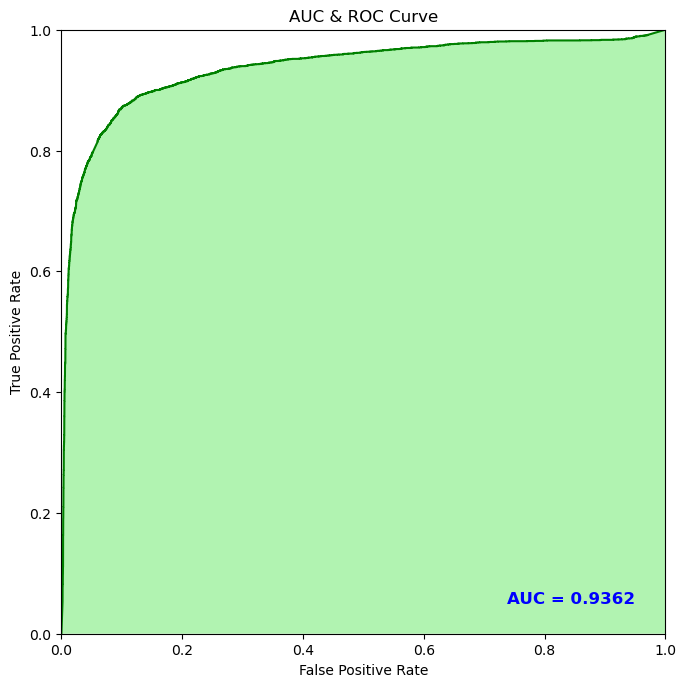

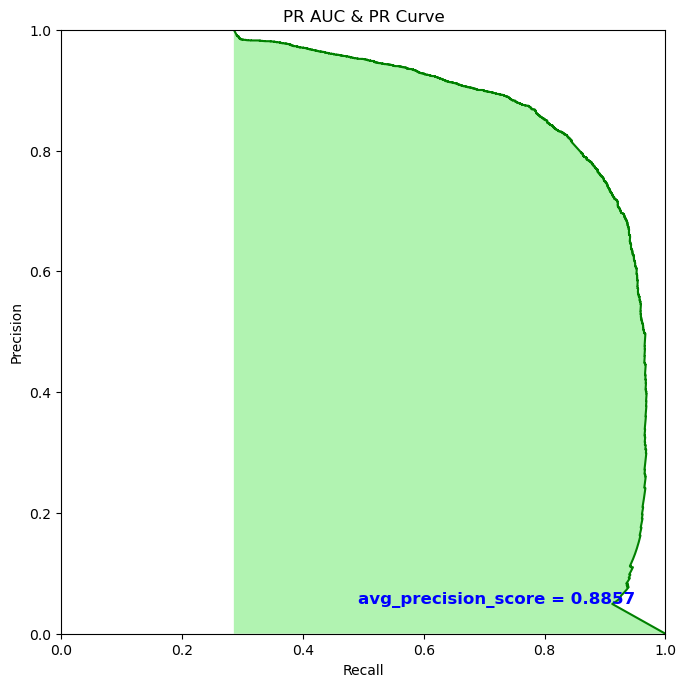

In [20]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
rocauc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
    tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
    fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
    tmp = pd.DataFrame.from_dict({'TPR' : tpr, 'FPR': fpr, 'precision': precision, 'recall': recall,'valAUC': rocauc, 'valPRAUC': prauc, 'method': 'NN'})
    tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'TPR' : true_positive_rate, 'FPR': false_positive_rate, 'precision': precision, 'recall': recall, 'valAUC': rocauc, 'valPRAUC': prauc, 'method': 'NN'})
tmp.to_csv('assets/auc_res_nn.tsv', sep='\t', float_format='%.18f')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % rocauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [21]:
h_eval_dict = h_model.evaluate(X_test_std, y_test, return_dict=True)

438/438 [==============================] - 7s 16ms/step - loss: 1.2703 - accuracy: 0.9052 - auc_2: 0.9372 - auc_3: 0.8912 - binary_fbeta: 0.8179


In [ ]:
# from sklearn.metrics import roc_curve, auc

# history = model.fit(x_train, y_train, validation_data=(
#         x_test, y_test), epochs=num_of_epochs, batch_size=batch_size, verbose=1)

# y_pred = model.predict(x_test).ravel()

# nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
# auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
# plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [24]:
from keras.models import model_from_json
model_json = h_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
h_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


##### Reload

In [2]:
from keras.models import model_from_json

# load json and create model
json_file = open('assets/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("assets/model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
# y_pred = loaded_model.predict(X_test_std)

Loaded model from disk


In [13]:
y_pred

array([[0.09220392],
       [0.4416806 ],
       [0.4416806 ],
       ...,
       [0.9561017 ],
       [0.82073677],
       [1.        ]], dtype=float32)

In [23]:
y_sc = y_pred[:, 0]
y_sc[::-1].sort()
print(y_sc[5600:5900])

[0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806 0.4416806
 0.441